In [3]:
from src.data import create_dataset, make_DataLoader, data_visualization

from src.model import Scene_Graph_Model

from src.utils import train_model, test_model, count_parameters, plot_loss, print_relationships

import torch as th

import numpy as np

# Data Generation

`NUM_IMAGES` images of simple geometric shapes (rectangles, circles and triangles) are going to be generated using matplotlib.

A random number of shapes (maximum in `MAX_OBJECTS`) will be placed on a `IMAGE_SIZE`x`IMAGE_SIZE` image with a white background, with random colors and positions.

The images and the corresponding annotations (class labels and bounding boxes) will be th.saved.

## Image generation

In [4]:
#Constants
TRAIN_IMAGE_DIR = 'train_images'
TEST_IMAGE_DIR = 'test_images'
DATA_DIR = 'data'
TRAIN_ANNOTATIONS = 'train_data.tensor'
TEST_ANNOTATIONS = 'test_data.tensor'
IMAGE_SIZE = 128
SHAPE_SIZE_MIN = 10
SHAPE_SIZE_MAX = 35
NUM_TRAIN_IMAGES = 10000
NUM_TEST_IMAGES = 2000
MAX_OBJECTS = 4

In [3]:
# Generate images
train_data, train_relationships = create_dataset(NUM_TRAIN_IMAGES, IMAGE_SIZE, TRAIN_IMAGE_DIR, MAX_OBJECTS, SHAPE_SIZE_MIN, SHAPE_SIZE_MAX, geometric=False, rotate=True, origami=True)

# save annotations
th.save(train_data, DATA_DIR + '/' + TRAIN_ANNOTATIONS)
th.save(train_relationships, DATA_DIR + '/train_relationships.tensor')

The directory train_images already exists. Do you want to delete it? [y/n]


Creating image dataset, size: 19.05 MB: 100%|██████████| 10000/10000 [07:08<00:00, 23.32it/s]


In [4]:
# Generate images
test_data, test_relationships = create_dataset(NUM_TEST_IMAGES, IMAGE_SIZE, TEST_IMAGE_DIR, MAX_OBJECTS, SHAPE_SIZE_MIN, SHAPE_SIZE_MAX, geometric=False, rotate=True, origami=True)

# save annotations
th.save(test_data, DATA_DIR + '/' + TEST_ANNOTATIONS)
th.save(test_relationships, DATA_DIR + "/test_relationships.tensor")

The directory test_images already exists. Do you want to delete it? [y/n]


Creating image dataset, size: 3.83 MB: 100%|██████████| 2000/2000 [01:25<00:00, 23.30it/s]


## Display Data

### Data Visualization

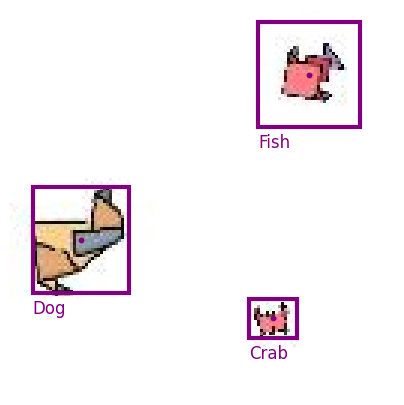

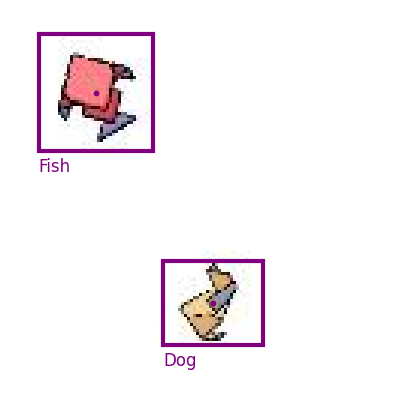

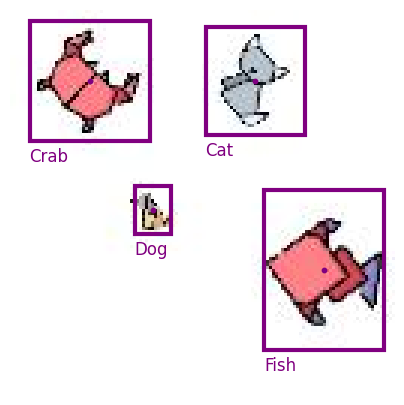

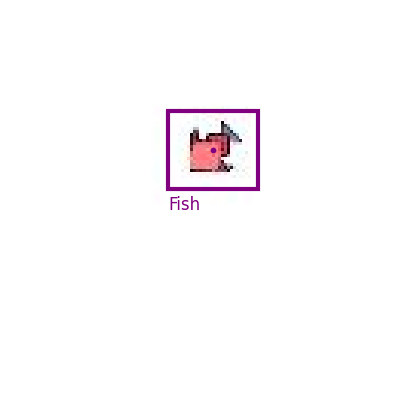

In [5]:
data_visualization(real=True, origami=True)

## DataLoader

### Image loading

In [5]:
make_DataLoader(TRAIN_IMAGE_DIR, TEST_IMAGE_DIR, IMAGE_SIZE, DATA_DIR, TRAIN_ANNOTATIONS, TEST_ANNOTATIONS)

Loading the images in test_images...: 100%|██████████| 2000/2000 [00:02<00:00, 974.19it/s] 


Loading Complete


# Model

In [6]:
train_loader = th.load('./dataloaders/train_loader.tensor')
test_loader = th.load('./dataloaders/test_loader.tensor')

In [20]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

#model = Scene_Graph_Model(num_boxes=5, num_classes=3, num_relation=6).to(device)
model = Scene_Graph_Model(num_boxes=4, num_classes=4, num_relation=6).to(device)

# criterion = lambda y_hat, y, relation_out, relation: th.nn.functional.cross_entropy(y_hat[:, 0, :4], y[:, 0, :4]) \
#                             + th.nn.functional.cross_entropy(y_hat[:, 1, :4], y[:, 1, :4]) \
#                             + th.nn.functional.cross_entropy(y_hat[:, 2, :4], y[:, 2, :4]) \
#                             + th.nn.functional.cross_entropy(y_hat[:, 3, :4], y[:, 3, :4]) \
#                             + th.nn.functional.cross_entropy(y_hat[:, 4, :4], y[:, 4, :4]) \
#                             + th.nn.functional.mse_loss(y_hat[:, :, 4:], y[:, :, 4:]) \
#                             + th.nn.functional.binary_cross_entropy_with_logits(relation_out, relation)

criterion = lambda y_hat, y, relation_out, relation: th.nn.functional.cross_entropy(y_hat[:, 0, :5], y[:, 0, :5]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 1, :5], y[:, 1, :5]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 2, :5], y[:, 2, :5]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 3, :5], y[:, 3, :5]) \
                                                   + th.nn.functional.mse_loss(y_hat[:, :, 5:], y[:, :, 5:]) \
                                                   + th.nn.functional.binary_cross_entropy_with_logits(relation_out, relation)

In [23]:
weights = th.load('./models/model_origami_without_rotations.pth')
model.load_state_dict(weights)

<All keys matched successfully>

In [9]:


criterion = lambda y_hat, y, relation_out, relation: th.nn.functional.cross_entropy(y_hat[:, 0, :4], y[:, 0, :4]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 1, :4], y[:, 1, :4]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 2, :4], y[:, 2, :4]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 3, :4], y[:, 3, :4]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 4, :4], y[:, 4, :4]) \
                                                   + th.nn.functional.mse_loss(y_hat[:, :, 4:], y[:, :, 4:]) \
                                                   + th.nn.functional.binary_cross_entropy_with_logits(relation_out, relation)

In [24]:
optimizer = th.optim.Adam(model.parameters(), lr=1e-4)
model, train_loss, test_loss = train_model(model, optimizer, criterion, train_loader, test_loader, 100)

Loss 8.3696/21.2230, Acc 0.92/0.92, Relation: 0.96/0.92: 100%|██████████| 100/100 [05:24<00:00,  3.24s/it]


For geometric images: 120 epochs

For origami without rotation: 200 epochs

For origami with rotation: 100 more epochs

For real images without rotation: 200 epochs

For real images with rotation: 200 more epochs

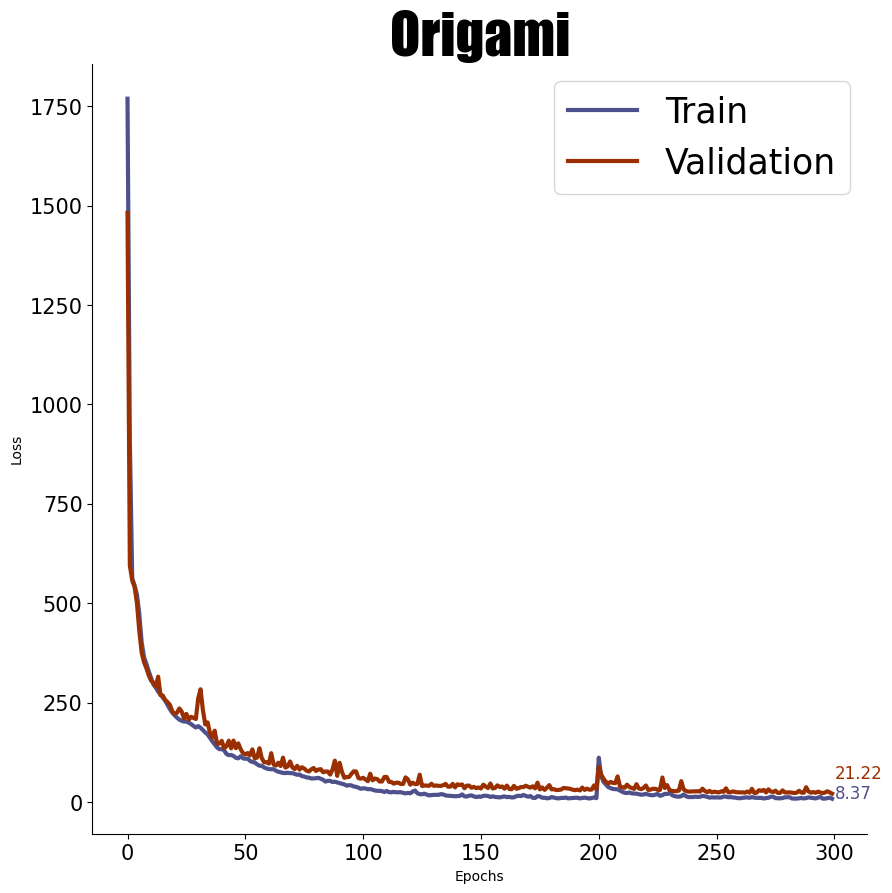

In [28]:
plot_loss(train_loss, test_loss, title = 'Origami')

In [3]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = Scene_Graph_Model(num_boxes=4, num_classes=4, num_relation=6).to(device)
# model = Scene_Graph_Model(num_boxes=5, num_classes=3, num_relation=6).to(device)
# weights = th.load('./models/best_geometric_model.pth')
weights = th.load('./models/best_origami_model.pth')
# weights = th.load('./models/best_realimage_model.pth')
model.load_state_dict(weights)

<All keys matched successfully>

Creating image dataset, size: 0.00 MB: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]
c:\Users\sandr\Documents\Code\Deep-Learning-Project\Deep-Learning-Project\src\utils.py:464: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  test_image_tensor = (th.from_numpy(test_image) - mu) / std


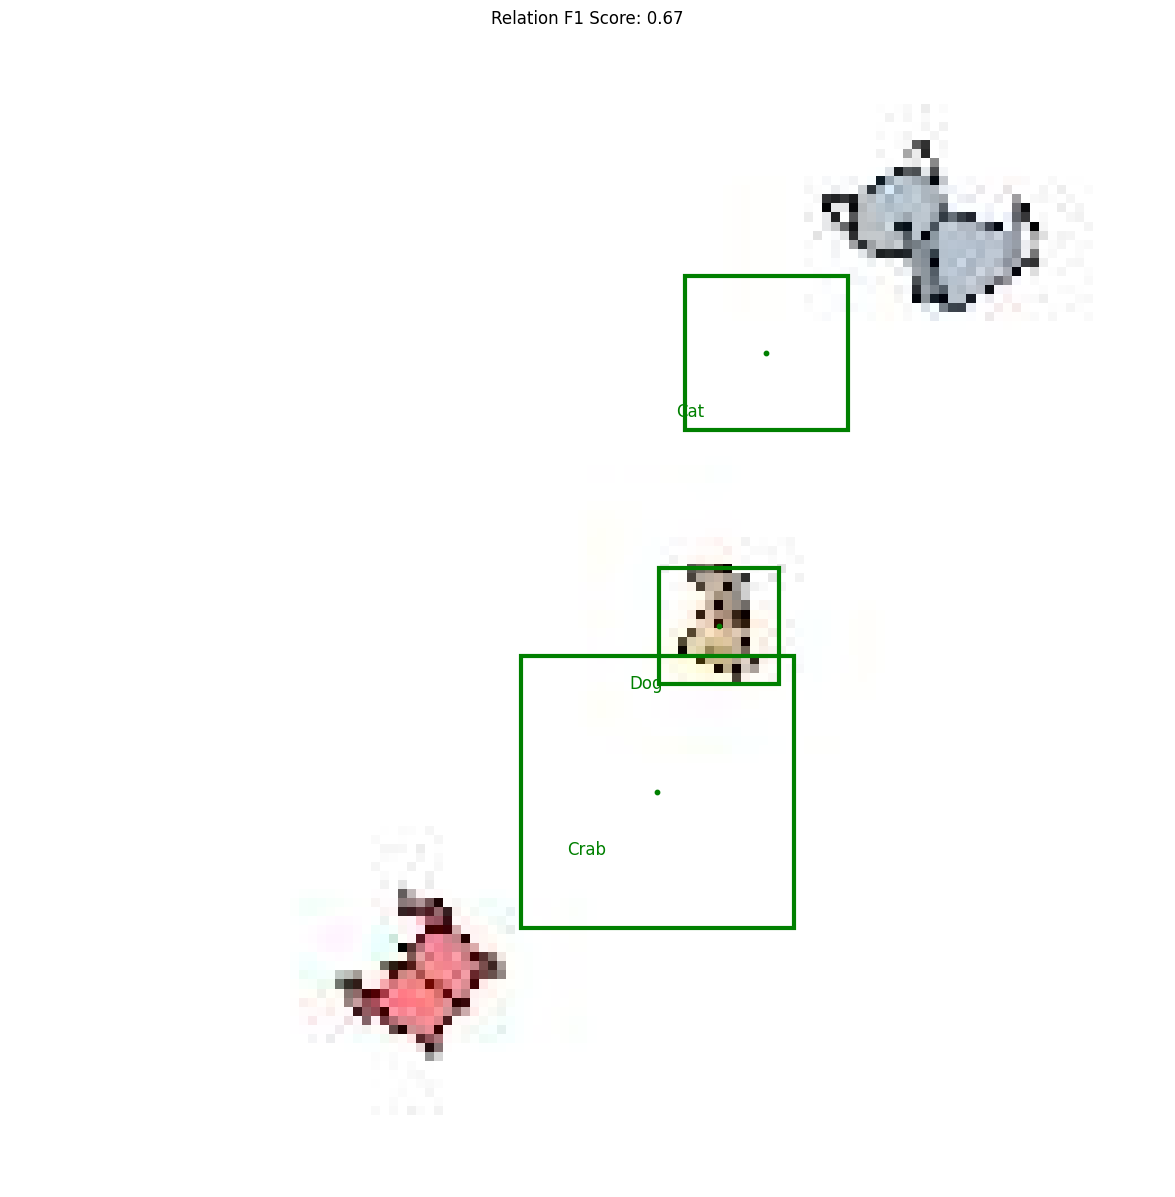

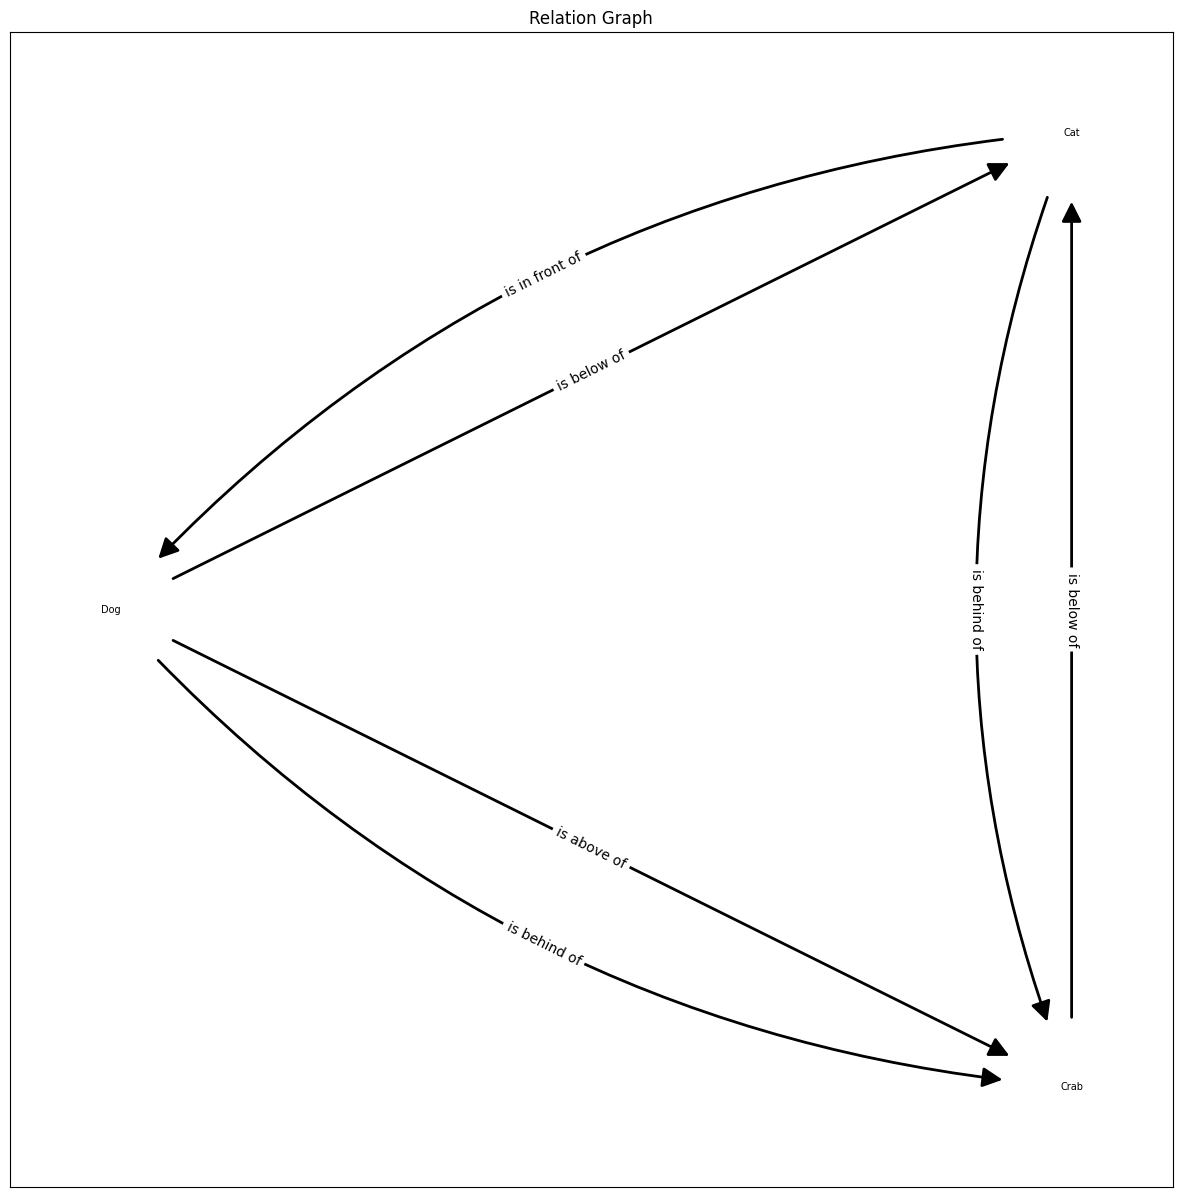

In [4]:
test_model(model, device, DATA_DIR, geometric=False, rotate=True, origami=True)

In [ ]:
print_relationships((th.sigmoid(out_relation[0]) > 0.5).int(), out)

NameError: name 'out_relation' is not defined

In [ ]:
print_relationships(relation[0], out)